Forecasting of partition datasets in route ../dataset/partitions
Target: averaged_queue_time_per_job
Book source: Timeseries forecasting in Python (Manning)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

Analysis of medium partition
Based on techniques from book Python Data Science Essentials and Timeseries forecasting in Python

In [2]:
medium_df = pd.read_csv("../dataset/partitions/medium_partition.csv", index_col=False)
medium_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
date,25716.0,1.679344e+09,2.710670e+06,1.674810e+09,1.676872e+09,1.679630e+09,1.681584e+09,1.683887e+09
availability,25708.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
avg_alloc_mem,25708.0,1.098207e+05,2.346865e+04,0.000000e+00,9.298000e+04,1.077664e+05,1.237000e+05,2.400000e+05
avg_allocated_cpus_per_job,25709.0,7.864055e+02,2.500667e+02,-1.000000e+00,6.256783e+02,7.642718e+02,8.918710e+02,2.880000e+03
avg_allocated_nodes_per_job,25709.0,3.071354e+00,9.788056e-01,-1.000000e+00,2.444056e+00,2.985437e+00,3.483871e+00,1.125000e+01
node_total,23796.0,1.334600e+03,6.302740e+01,3.000000e+00,1.324000e+03,1.361000e+03,1.368000e+03,1.379000e+03
avg_cpus_load_lower,25708.0,7.681426e+01,1.689330e+02,0.000000e+00,3.636600e+01,5.250792e+01,6.806125e+01,1.664107e+03
nodes,23796.0,1.334600e+03,6.302740e+01,3.000000e+00,1.324000e+03,1.361000e+03,1.368000e+03,1.379000e+03
avg_cpus_load_upper,25708.0,1.675540e+02,2.422030e+02,2.000000e-02,9.505513e+01,1.106183e+02,1.301676e+02,3.910001e+03
avg_execution_time_per_job,25709.0,5.340006e+04,1.340223e+04,-1.000000e+00,4.452556e+04,5.238777e+04,6.160673e+04,1.862302e+05


In [3]:
# 1- detect columns to drop based on occurrence of null values (>1%)
null_values = medium_df.isnull().sum() * 100 / len(medium_df) # values gives the % of null values for each feature
columns_to_drop= null_values > 1.0
columns_to_drop = medium_df.loc[:, columns_to_drop].columns
# 1- Remove features with significant number of null values
medium_df.drop(columns_to_drop, axis=1, inplace=True)
# Remove rows with null values
medium_df.dropna(inplace=True)

In [4]:
# 1- convert date to time index
medium_df['date'] = pd.to_datetime(medium_df['date'].astype(np.int64), unit='s') 
medium_df.set_index('date', inplace=True)
# 2- remove features with no variance
filter = medium_df.std() == 0
features_to_drop = medium_df.columns[filter]
medium_df.drop(features_to_drop, axis=1, inplace=True)
medium_df.describe().transpose()  
# Sort time index
medium_df.sort_index(inplace=True)

Our target is to forecast the avg_queue_time_per_job based on other features in dataset

In [5]:
a_day_period = 12*24
a_week_period = 7 * a_day_period
full_dataset_len = len(medium_df)

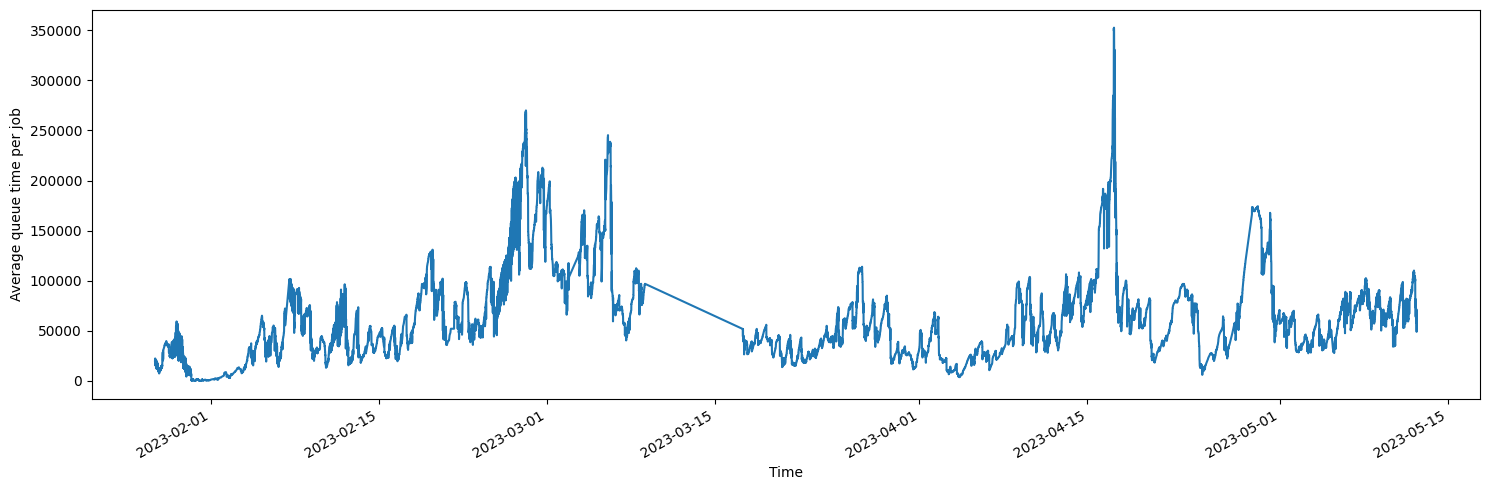

In [6]:
avg_job_queue_time = medium_df['avg_queue_time_per_job'][0:full_dataset_len]
time_index = medium_df.index[0:full_dataset_len]
fig, ax = plt.subplots()
ax.set_xlabel("Time")
ax.set_ylabel("Average queue time per job")
fig.set_size_inches(15, 5)
ax.plot(time_index, avg_job_queue_time)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

Analyse seasonality with Fast Fourier Transform (FFT)
No seasonality is detected

2023-05-22 15:53:37.351573: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-22 15:53:37.464629: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-22 15:53:37.465862: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 15:53:38.755775: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


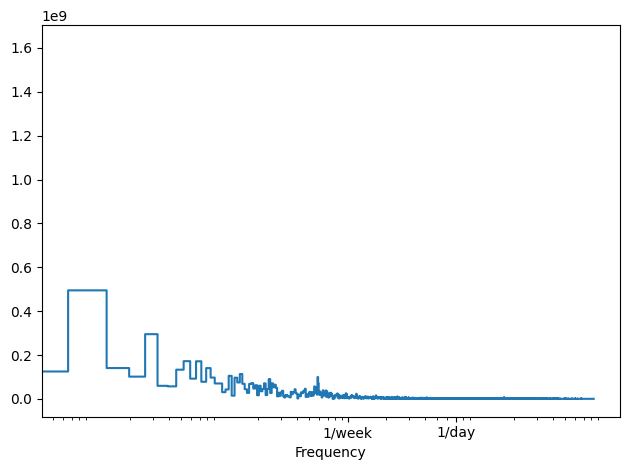

In [7]:
import tensorflow as tf
fft = tf.signal.rfft(medium_df['avg_queue_time_per_job'])

f_per_dataset = np.arange(0, len(fft))
n_sample_h = len(medium_df['avg_queue_time_per_job'])

hours_per_week = 24 * 7
weeks_per_dataset = n_sample_h / hours_per_week
f_per_week = f_per_dataset / weeks_per_dataset

plt.step(f_per_week, np.abs(fft))
plt.xscale('log')
plt.xticks([1, 7], ['1/week', '1/day'])
plt.xlabel('Frequency')

plt.tight_layout()
plt.show()


In [8]:
def determine_dropped_colums(df: pd.core.frame.DataFrame, df_selected: np.ndarray):
    original_columns = df.columns
    dropped_columns = []
    index = -1
    for value in df.iloc[0]:
        index += 1
        if value not in df_selected[0]:
            dropped_columns.append(original_columns[index])
    return dropped_columns

Feature selection: drop features with low variance

In [9]:
from sklearn.feature_selection import VarianceThreshold
medium_df_selected = VarianceThreshold(threshold=1.0).fit_transform(medium_df)
dropped_columns = determine_dropped_colums(medium_df, medium_df_selected)
old_columns = medium_df.columns
new_columns = old_columns.drop(dropped_columns)
medium_df_selected = pd.DataFrame(medium_df_selected, columns=new_columns, index=medium_df.index)
medium_df_selected.describe().transpose()
# These columns should have been removed from dataset: avg_allocated_nodes_per_job, avg_maximum_allocated_nodes_per_job, avg_minimum_requested_nodes_per_job

,count,mean,std,min,25%,50%,75%,max
avg_alloc_mem,25708.0,109820.712528,23468.654668,0.000000,92980.000000,107766.400000,123700.000000,240000.000000
avg_allocated_cpus_per_job,25708.0,786.394447,250.065269,-1.000000,625.678322,764.271845,891.785421,2880.000000
avg_cpus_load_lower,25708.0,76.814262,168.933019,0.000000,36.366000,52.507917,68.061250,1664.106667
avg_cpus_load_upper,25708.0,167.554043,242.202998,0.020000,95.055125,110.618333,130.167625,3910.001250
avg_execution_time_per_job,25708.0,53398.963446,13401.336650,-1.000000,44523.394166,52387.769912,61606.734940,186230.188144
avg_free_mem_lower,25708.0,187403.889372,18781.242197,7658.000000,179463.487500,190560.714286,199657.000000,246061.000000
avg_free_mem_upper,25708.0,234923.756764,7533.645046,160283.750000,230433.888889,236088.500000,240407.025000,249717.000000
avg_maximum_allocated_cpus_per_job,25708.0,671.881426,184.698289,203.279597,539.899576,655.960591,774.701571,1529.901679
avg_minimum_requested_cpus_per_job,25708.0,108.676288,16.093355,40.965278,100.820494,113.756863,120.081916,149.077244
avg_minimum_requested_memory_per_job,25708.0,214627.652140,33484.517983,60568.814480,202547.222378,231458.812227,236067.187328,240000.000000


Split dataset into train, validation and test

In [10]:
X_columns = medium_df_selected.columns.drop("avg_queue_time_per_job")
X = medium_df_selected[X_columns]
y = medium_df_selected["avg_queue_time_per_job"]

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [12]:
n = len(medium_df_selected)
train_df = medium_df_selected[0:int(0.7*n)] # 70% 
val_df = medium_df_selected[int(0.7*n):int(0.9*n)] # 20%
test_df = medium_df_selected[int(0.9*n):] # 10%

Scale dataset to range [0, 1] for better ML model performance and lower training time

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_df)
columns = train_df.columns
index = train_df.index
train_df = pd.DataFrame(scaler.transform(train_df[train_df.columns]), columns=train_df.columns, index=train_df.index)
val_df = pd.DataFrame(scaler.transform(val_df[val_df.columns]), columns=val_df.columns, index=val_df.index)
test_df = pd.DataFrame(scaler.transform(test_df[test_df.columns]), columns=test_df.columns, index=test_df.index)

Data windowing
Code taken from TimeSeries Forecasting in Python: https://github.com/marcopeix/TimeSeriesForecastingInPython/blob/master/CH13%26CH14/CH13%20%26%20CH14.ipynb

In [14]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='avg_queue_time_per_job', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

1- Defining baseline models (for performance comparison)

In [15]:
from keras import Model, Sequential

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.losses import MeanSquaredError
from keras.metrics import MeanAbsoluteError, MeanAbsolutePercentageError, MeanRelativeError

from keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell, GRU

import warnings
warnings.filterwarnings('ignore')

1.1- Single-step baseline model

In [16]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['avg_queue_time_per_job'])
wide_window = DataWindow(input_width=a_day_period, label_width=a_day_period, shift=a_day_period, label_columns=['avg_queue_time_per_job'])

In [17]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        
        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)
        
        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

In [18]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}
baseline_last = Baseline(label_index=column_indices['avg_queue_time_per_job'])
baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError()])

In [19]:
val_performance = {}
performance = {}

In [20]:
val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)

2023-05-22 15:54:11.964544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [5141]
	 [[{{node Placeholder/_8}}]]
2023-05-22 15:54:11.965288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


161/161 [==============================] - 1s 2ms/step - loss: 3.3392e-04 - mean_absolute_error: 0.0042 - mean_absolute_percentage_error: 1.6693


2023-05-22 15:54:12.575829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [2571,16]
	 [[{{node Placeholder/_0}}]]
2023-05-22 15:54:12.576422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


2023-05-22 15:54:15.741296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [17420]
	 [[{{node Placeholder/_8}}]]
2023-05-22 15:54:15.741844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [17420]
	 [[{{node Placeholder/_8}}]]


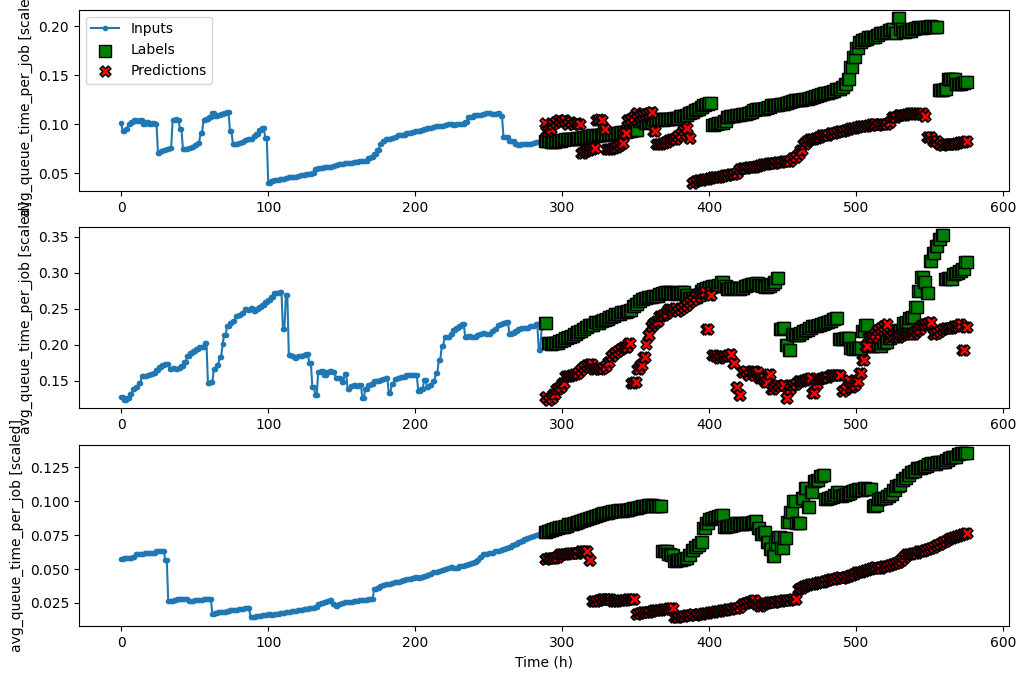

In [21]:
wide_window.plot(baseline_last)

In [22]:
print(performance['Baseline - Last'][2])

1.7589576244354248


1.2- Multi-step baseline models

In [23]:
#Below ML techniques require the input and label set to have the same dimension, so the input_width and label_width must be identical
#FIXME investigate ML models where input_width and label_witdh could be different
multi_window = DataWindow(input_width=a_day_period, label_width=a_day_period, shift=a_day_period, label_columns=['avg_queue_time_per_job'])

1.2.1- Predicting the last known value

In [24]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_width, label_index=None):
        super().__init__()
        self.label_index = label_index
        self.label_width = label_width
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, self.label_width, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, self.label_width, 1])

In [25]:
ms_val_performance = {}
ms_performance = {}

In [26]:
ms_baseline_last = MultiStepLastBaseline(label_width=a_day_period, label_index=column_indices['avg_queue_time_per_job'])
ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError()])

ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)
ms_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

  1/143 [..............................] - ETA: 28s - loss: 0.0536 - mean_absolute_error: 0.1789 - mean_absolute_percentage_error: 85.5762

2023-05-22 15:54:41.011346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [5142,16]
	 [[{{node Placeholder/_0}}]]
2023-05-22 15:54:41.011857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


143/143 [==============================] - 1s 3ms/step - loss: 0.0557 - mean_absolute_error: 0.1780 - mean_absolute_percentage_error: 78.9673


2023-05-22 15:54:41.708254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1996]
	 [[{{node Placeholder/_8}}]]
2023-05-22 15:54:41.709055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


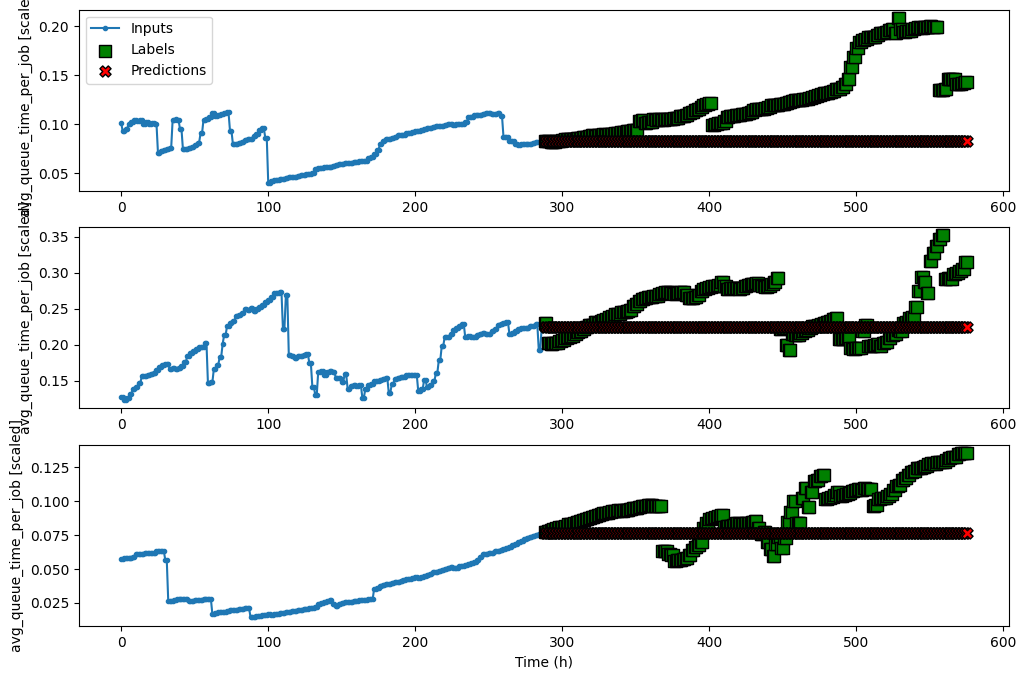

In [27]:
wide_window.plot(ms_baseline_last)

In [28]:
print(ms_performance['Baseline - Last'][2])

58.18465042114258


1.2.2- Repeating the input sequence

In [29]:
class RepeatBaseline(Model):
    def __init__(self, label_width, label_index=None):
        super().__init__()
        self.label_index = label_index
        self.label_width = label_width
        
    def call(self, inputs):

        return inputs[:, -self.label_width:, self.label_index:]

In [30]:
ms_baseline_repeat = RepeatBaseline(a_day_period, label_index=column_indices['avg_queue_time_per_job'])
ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError()])
ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)
ms_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0)

  1/143 [..............................] - ETA: 25s - loss: 0.0549 - mean_absolute_error: 0.1801 - mean_absolute_percentage_error: 92.0133

2023-05-22 15:54:53.630736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-05-22 15:54:53.631285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


143/143 [==============================] - 1s 3ms/step - loss: 0.0601 - mean_absolute_error: 0.1895 - mean_absolute_percentage_error: 85.8620


2023-05-22 15:54:54.272926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [2571,16]
	 [[{{node Placeholder/_0}}]]
2023-05-22 15:54:54.273804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


60.327945709228516


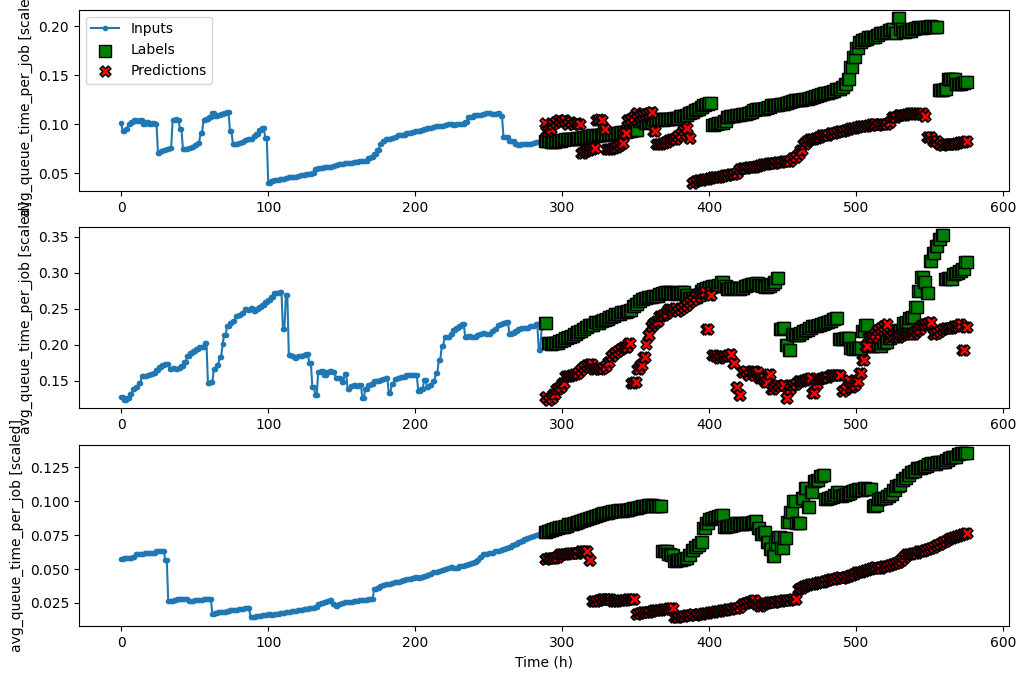

In [31]:
wide_window.plot(ms_baseline_repeat)
print(ms_performance['Baseline - Repeat'][2])

2- Linear model

In [32]:
def compile_and_fit(model, window, patience=3, max_epochs=100):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

2.1- Single step linear model

In [33]:
ss_linear_model = Sequential(
    [
        Dense(units=1) # Number of units is output layer == number of output classes
    ]
)


In [34]:
history = compile_and_fit(model=ss_linear_model,window=single_step_window)
val_performance['Linear'] = ss_linear_model.evaluate(single_step_window.val)
performance['Linear'] = ss_linear_model.evaluate(single_step_window.test, verbose=0)

Epoch 1/100


2023-05-22 15:55:08.492587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [17995,16]
	 [[{{node Placeholder/_0}}]]
2023-05-22 15:55:08.493250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [17995,16]
	 [[{{node Placeholder/_0}}]]


543/563 [===========================>..] - ETA: 0s - loss: 0.0563 - mean_absolute_error: 0.1769 - mean_absolute_percentage_error: 11966.7197

2023-05-22 15:55:10.043976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-05-22 15:55:10.044494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


563/563 [==============================] - 2s 2ms/step - loss: 0.0557 - mean_absolute_error: 0.1760 - mean_absolute_percentage_error: 11565.9434 - val_loss: 0.0602 - val_mean_absolute_error: 0.1776 - val_mean_absolute_percentage_error: 60.8307
Epoch 2/100
563/563 [==============================] - 1s 2ms/step - loss: 0.0284 - mean_absolute_error: 0.1285 - mean_absolute_percentage_error: 6419.2241 - val_loss: 0.0332 - val_mean_absolute_error: 0.1333 - val_mean_absolute_percentage_error: 45.5341
Epoch 3/100
563/563 [==============================] - 1s 2ms/step - loss: 0.0146 - mean_absolute_error: 0.0936 - mean_absolute_percentage_error: 1459.3939 - val_loss: 0.0172 - val_mean_absolute_error: 0.0971 - val_mean_absolute_percentage_error: 33.9010
Epoch 4/100
563/563 [==============================] - 1s 2ms/step - loss: 0.0073 - mean_absolute_error: 0.0668 - mean_absolute_percentage_error: 2983.8953 - val_loss: 0.0083 - val_mean_absolute_error: 0.0679 - val_mean_absolute_percentage_error:

2023-05-22 15:55:33.479100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [5141]
	 [[{{node Placeholder/_8}}]]
2023-05-22 15:55:33.479625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [5142,16]
	 [[{{node Placeholder/_0}}]]


161/161 [==============================] - 0s 2ms/step - loss: 3.5158e-04 - mean_absolute_error: 0.0068 - mean_absolute_percentage_error: 3.0152


2023-05-22 15:55:33.902259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [2571,16]
	 [[{{node Placeholder/_0}}]]
2023-05-22 15:55:33.902787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [2570]
	 [[{{node Placeholder/_8}}]]


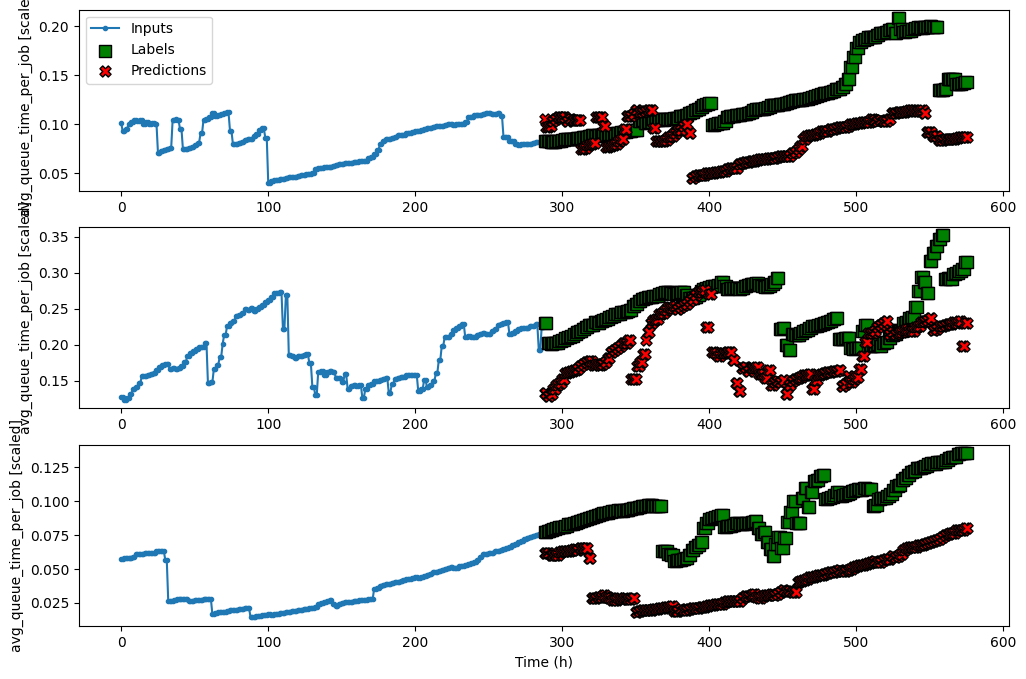

In [35]:
wide_window.plot(ss_linear_model)

In [36]:
print('Single step Performance:')
for index, key in enumerate(performance):
    print(key + ": " + str(performance[key][2]))
print('Single step Validation Performance:')
for index, key in enumerate(val_performance):
    print(key + ": " + str(val_performance[key][2]))

Single step Performance:
Baseline - Last: 1.7589576244354248
Linear: 3.1603853702545166
Single step Validation Performance:
Baseline - Last: 1.6693339347839355
Linear: 3.015242338180542


2.2- Multistep linear model

In [37]:
ms_linear_model = Sequential(
    [
        Dense(units=1, kernel_initializer=tf.initializers.zeros)
    ]
)

In [38]:
history = compile_and_fit(model=ms_linear_model,window=wide_window)
ms_val_performance["Linear"] = ms_linear_model.evaluate(wide_window.val)
ms_performance["Linear"] = ms_linear_model.evaluate(wide_window.test, verbose=0)

Epoch 1/100


2023-05-22 15:56:54.221972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [17420]
	 [[{{node Placeholder/_8}}]]
2023-05-22 15:56:54.222630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [17995,16]
	 [[{{node Placeholder/_0}}]]


532/545 [============================>.] - ETA: 0s - loss: 0.0215 - mean_absolute_error: 0.1051 - mean_absolute_percentage_error: 20116.4043

2023-05-22 15:56:56.163435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [5142,16]
	 [[{{node Placeholder/_0}}]]
2023-05-22 15:56:56.164360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [5142,16]
	 [[{{node Placeholder/_0}}]]


545/545 [==============================] - 2s 3ms/step - loss: 0.0213 - mean_absolute_error: 0.1046 - mean_absolute_percentage_error: 20271.8105 - val_loss: 0.0344 - val_mean_absolute_error: 0.1246 - val_mean_absolute_percentage_error: 45.6750
Epoch 2/100
545/545 [==============================] - 2s 3ms/step - loss: 0.0129 - mean_absolute_error: 0.0815 - mean_absolute_percentage_error: 15265.7354 - val_loss: 0.0324 - val_mean_absolute_error: 0.1263 - val_mean_absolute_percentage_error: 48.2833
Epoch 3/100
545/545 [==============================] - 2s 4ms/step - loss: 0.0117 - mean_absolute_error: 0.0785 - mean_absolute_percentage_error: 13054.4443 - val_loss: 0.0321 - val_mean_absolute_error: 0.1275 - val_mean_absolute_percentage_error: 50.2879
Epoch 4/100
545/545 [==============================] - 1s 3ms/step - loss: 0.0115 - mean_absolute_error: 0.0783 - mean_absolute_percentage_error: 12549.6777 - val_loss: 0.0321 - val_mean_absolute_error: 0.1280 - val_mean_absolute_percentage_err

2023-05-22 15:57:05.736639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [4567]
	 [[{{node Placeholder/_8}}]]
2023-05-22 15:57:05.737230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


143/143 [==============================] - 0s 2ms/step - loss: 0.0322 - mean_absolute_error: 0.1283 - mean_absolute_percentage_error: 51.1233


2023-05-22 15:57:06.071948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-05-22 15:57:06.072770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [2571,16]
	 [[{{node Placeholder/_0}}]]


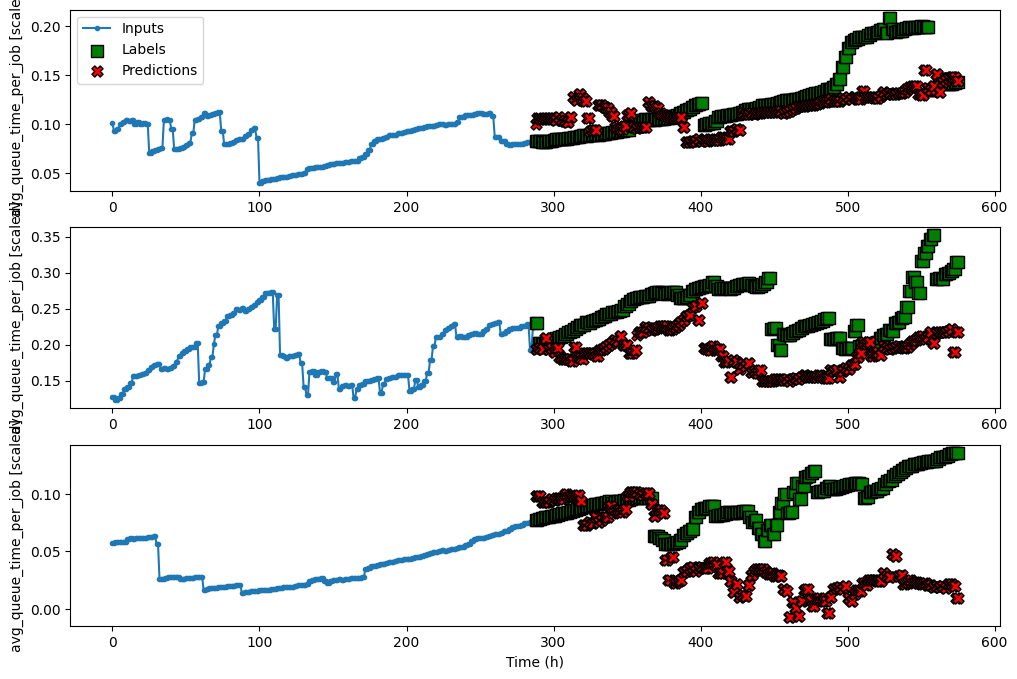

In [39]:
wide_window.plot(ms_linear_model)

In [40]:
print('Multistep Performance:')
for index, key in enumerate(ms_performance):
    print(key + ": " + str(ms_performance[key][2]))
print('Multistep Validation Performance:')
for index, key in enumerate(ms_val_performance):
    print(key + ": " + str(ms_val_performance[key][2]))

Multistep Performance:
Baseline - Last: 58.18465042114258
Baseline - Repeat: 60.327945709228516
Linear: 27.553590774536133
Multistep Validation Performance:
Baseline - Last: 78.96725463867188
Baseline - Repeat: 85.86195373535156
Linear: 51.12327575683594


3- Deep Neural (DNN) model 

3.2- Single step DNN model

In [41]:
ss_dnn_model = Sequential(
    [
        Dense(units=64, activation='relu'),
        Dense(units=64, activation='relu'),
        Dense(units=1)
    ]
)

In [42]:
history = compile_and_fit(model=ss_dnn_model, window=single_step_window)
val_performance['DNN'] = ss_dnn_model.evaluate(single_step_window.val)
performance['DNN'] = ss_dnn_model.evaluate(single_step_window.test, verbose=0)

Epoch 1/100


2023-05-22 16:04:29.272453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [17994]
	 [[{{node Placeholder/_8}}]]
2023-05-22 16:04:29.273435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


558/563 [============================>.] - ETA: 0s - loss: 0.0023 - mean_absolute_error: 0.0218 - mean_absolute_percentage_error: 1212.6257

2023-05-22 16:04:31.540402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [5141]
	 [[{{node Placeholder/_8}}]]
2023-05-22 16:04:31.542062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [5142,16]
	 [[{{node Placeholder/_0}}]]


563/563 [==============================] - 3s 4ms/step - loss: 0.0023 - mean_absolute_error: 0.0218 - mean_absolute_percentage_error: 1203.4265 - val_loss: 7.9200e-04 - val_mean_absolute_error: 0.0212 - val_mean_absolute_percentage_error: 9.2673
Epoch 2/100
563/563 [==============================] - 2s 3ms/step - loss: 3.4774e-04 - mean_absolute_error: 0.0103 - mean_absolute_percentage_error: 1128.1178 - val_loss: 4.1962e-04 - val_mean_absolute_error: 0.0084 - val_mean_absolute_percentage_error: 3.0230
Epoch 3/100
563/563 [==============================] - 2s 3ms/step - loss: 3.3524e-04 - mean_absolute_error: 0.0098 - mean_absolute_percentage_error: 255.3349 - val_loss: 4.3904e-04 - val_mean_absolute_error: 0.0101 - val_mean_absolute_percentage_error: 3.9500
Epoch 4/100
563/563 [==============================] - 2s 3ms/step - loss: 3.4002e-04 - mean_absolute_error: 0.0103 - mean_absolute_percentage_error: 949.6293 - val_loss: 3.9669e-04 - val_mean_absolute_error: 0.0077 - val_mean_abso

2023-05-22 16:04:45.311291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-05-22 16:04:45.311868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [5141]
	 [[{{node Placeholder/_8}}]]


161/161 [==============================] - 0s 2ms/step - loss: 3.9590e-04 - mean_absolute_error: 0.0104 - mean_absolute_percentage_error: 4.3732


2023-05-22 16:04:45.838559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-05-22 16:04:45.839813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


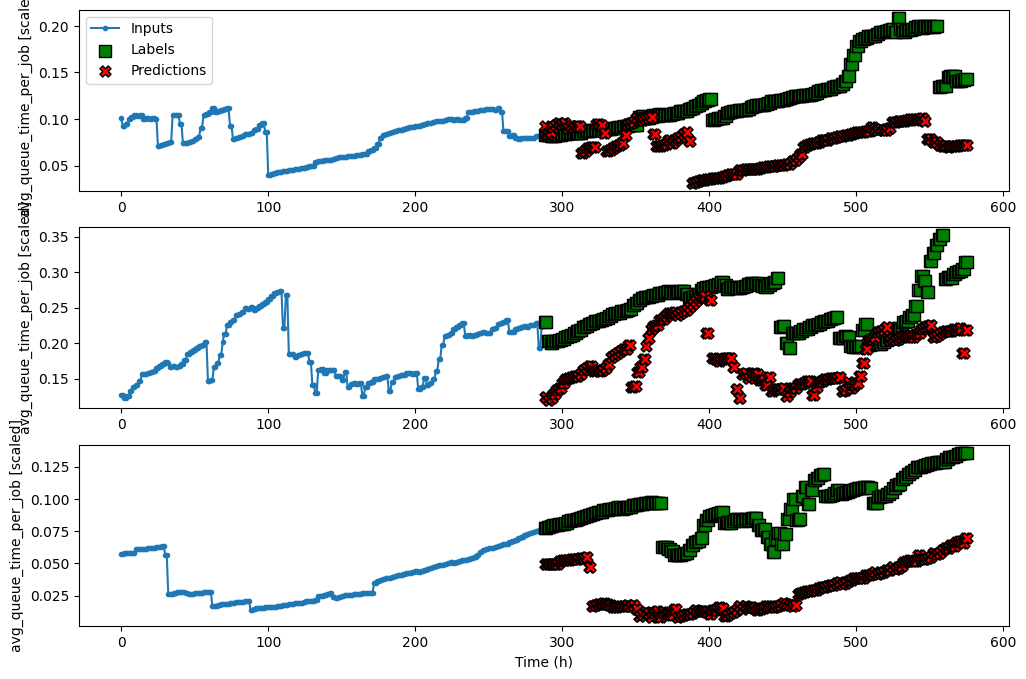

In [43]:
wide_window.plot(ss_dnn_model)

In [44]:
print('Single step Performance:')
for index, key in enumerate(performance):
    print(key + ": " + str(performance[key][2]))
print('Single step Validation Performance:')
for index, key in enumerate(val_performance):
    print(key + ": " + str(val_performance[key][2]))

Single step Performance:
Baseline - Last: 1.7589576244354248
Linear: 3.1603853702545166
DNN: 4.934330463409424
Single step Validation Performance:
Baseline - Last: 1.6693339347839355
Linear: 3.015242338180542
DNN: 4.373223304748535


3.3- Multistep DNN model

In [45]:
ms_dnn_model = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

In [46]:
history = compile_and_fit(model=ms_dnn_model, window=multi_window)
ms_val_performance['DNN'] = ms_dnn_model.evaluate(multi_window.val)
ms_performance['DNN'] = ms_dnn_model.evaluate(multi_window.test, verbose=0)

Epoch 1/100


2023-05-22 16:06:08.898751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-05-22 16:06:08.899374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [17420]
	 [[{{node Placeholder/_8}}]]


542/545 [============================>.] - ETA: 0s - loss: 0.0122 - mean_absolute_error: 0.0777 - mean_absolute_percentage_error: 8351.3916

2023-05-22 16:06:15.116773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-05-22 16:06:15.117455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [4567]
	 [[{{node Placeholder/_8}}]]


545/545 [==============================] - 7s 12ms/step - loss: 0.0122 - mean_absolute_error: 0.0776 - mean_absolute_percentage_error: 8315.1729 - val_loss: 0.0244 - val_mean_absolute_error: 0.1144 - val_mean_absolute_percentage_error: 46.3338
Epoch 2/100
545/545 [==============================] - 6s 11ms/step - loss: 0.0059 - mean_absolute_error: 0.0554 - mean_absolute_percentage_error: 2354.2214 - val_loss: 0.0266 - val_mean_absolute_error: 0.1212 - val_mean_absolute_percentage_error: 47.1190
Epoch 3/100
545/545 [==============================] - 5s 10ms/step - loss: 0.0044 - mean_absolute_error: 0.0476 - mean_absolute_percentage_error: 1718.7736 - val_loss: 0.0303 - val_mean_absolute_error: 0.1293 - val_mean_absolute_percentage_error: 49.7058
Epoch 4/100
 21/143 [===>..........................] - ETA: 0s - loss: 0.0332 - mean_absolute_error: 0.1346 - mean_absolute_percentage_error: 52.8967

2023-05-22 16:06:32.810891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [5142,16]
	 [[{{node Placeholder/_0}}]]
2023-05-22 16:06:32.811436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


143/143 [==============================] - 1s 6ms/step - loss: 0.0329 - mean_absolute_error: 0.1333 - mean_absolute_percentage_error: 51.8865


2023-05-22 16:06:33.771290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-05-22 16:06:33.771970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


In [47]:
print('Multistep Performance:')
for index, key in enumerate(ms_performance):
    print(key + ": " + str(ms_performance[key][2]))
print('Multistep Validation Performance:')
for index, key in enumerate(ms_val_performance):
    print(key + ": " + str(ms_val_performance[key][2]))

Multistep Performance:
Baseline - Last: 58.18465042114258
Baseline - Repeat: 60.327945709228516
Linear: 27.553590774536133
DNN: 36.25695037841797
Multistep Validation Performance:
Baseline - Last: 78.96725463867188
Baseline - Repeat: 85.86195373535156
Linear: 51.12327575683594
DNN: 51.88646697998047


In [48]:
def plot_performance(performance, val_performance, low_ylim=0.0, high_ylim=1.0, title=''):
    ms_mae_val = [v[2] for v in val_performance.values()]
    ms_mae_test = [v[2] for v in performance.values()]
    x = np.arange(len(performance))
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 5)
    ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
    ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
    ax.set_ylabel('MeanAbsolutePercentageError')
    ax.set_xlabel('Models')
    for index, value in enumerate(ms_mae_val):
        plt.text(x=index - 0.15, y=value+0.05, s=str(round(value, 3)), ha='center')
    for index, value in enumerate(ms_mae_test):
        plt.text(x=index + 0.15, y=value+0.05, s=str(round(value, 3)), ha='center')
    # plt.ylim(low_ylim, high_ylim)
    plt.xticks(ticks=x, labels=performance.keys())
    plt.legend(loc='best')
    plt.title(title)
    plt.tight_layout()




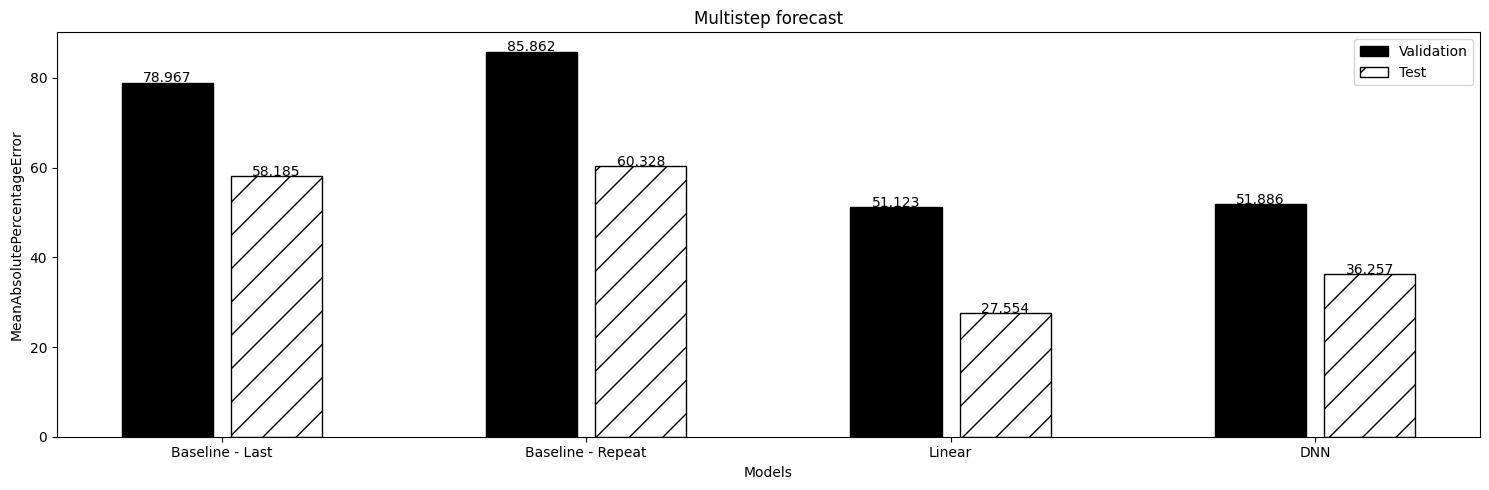

In [50]:
plot_performance(ms_performance, ms_val_performance, high_ylim=0.3, title='Multistep forecast')
#plot_performance(performance, val_performance, high_ylim=0.2, title='Single step forecast')

4- Long short term memory (LSTM) model 

4.1 LSTM single step model

In [51]:
ss_lstm_model = Sequential([
    LSTM(units=32, return_sequences=True),
    Dense(units=1)
])

In [52]:
history = compile_and_fit(model=ss_lstm_model, window=single_step_window)
val_performance['LSTM'] = ss_lstm_model.evaluate(single_step_window.val)
performance['LSTM'] = ss_lstm_model.evaluate(single_step_window.test, verbose=0)

Epoch 1/100


2023-05-22 16:06:58.652130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [17995,16]
	 [[{{node Placeholder/_0}}]]
2023-05-22 16:06:58.652735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [17995,16]
	 [[{{node Placeholder/_0}}]]
2023-05-22 16:06:59.000500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split

555/563 [============================>.] - ETA: 0s - loss: 0.0046 - mean_absolute_error: 0.0361 - mean_absolute_percentage_error: 854.2139

2023-05-22 16:07:02.952839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [5142,16]
	 [[{{node Placeholder/_0}}]]
2023-05-22 16:07:02.953568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [5141]
	 [[{{node Placeholder/_8}}]]
2023-05-22 16:07:03.235307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim'

563/563 [==============================] - 5s 5ms/step - loss: 0.0046 - mean_absolute_error: 0.0358 - mean_absolute_percentage_error: 843.7273 - val_loss: 3.7603e-04 - val_mean_absolute_error: 0.0076 - val_mean_absolute_percentage_error: 2.9582
Epoch 2/100
563/563 [==============================] - 2s 4ms/step - loss: 3.2767e-04 - mean_absolute_error: 0.0088 - mean_absolute_percentage_error: 142.3806 - val_loss: 3.9044e-04 - val_mean_absolute_error: 0.0091 - val_mean_absolute_percentage_error: 3.4474
Epoch 3/100
563/563 [==============================] - 2s 4ms/step - loss: 3.1402e-04 - mean_absolute_error: 0.0083 - mean_absolute_percentage_error: 145.3667 - val_loss: 3.9810e-04 - val_mean_absolute_error: 0.0090 - val_mean_absolute_percentage_error: 3.7937
Epoch 4/100
 49/161 [========>.....................] - ETA: 0s - loss: 2.1607e-04 - mean_absolute_error: 0.0075 - mean_absolute_percentage_error: 3.0380

2023-05-22 16:07:10.644662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-05-22 16:07:10.645254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


161/161 [==============================] - 0s 2ms/step - loss: 3.8295e-04 - mean_absolute_error: 0.0079 - mean_absolute_percentage_error: 3.0742


2023-05-22 16:07:11.101173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [2571,16]
	 [[{{node Placeholder/_0}}]]
2023-05-22 16:07:11.101947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [2570]
	 [[{{node Placeholder/_8}}]]


2023-05-22 16:07:11.602879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-22 16:07:11.606620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-22 16:07:11.608581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

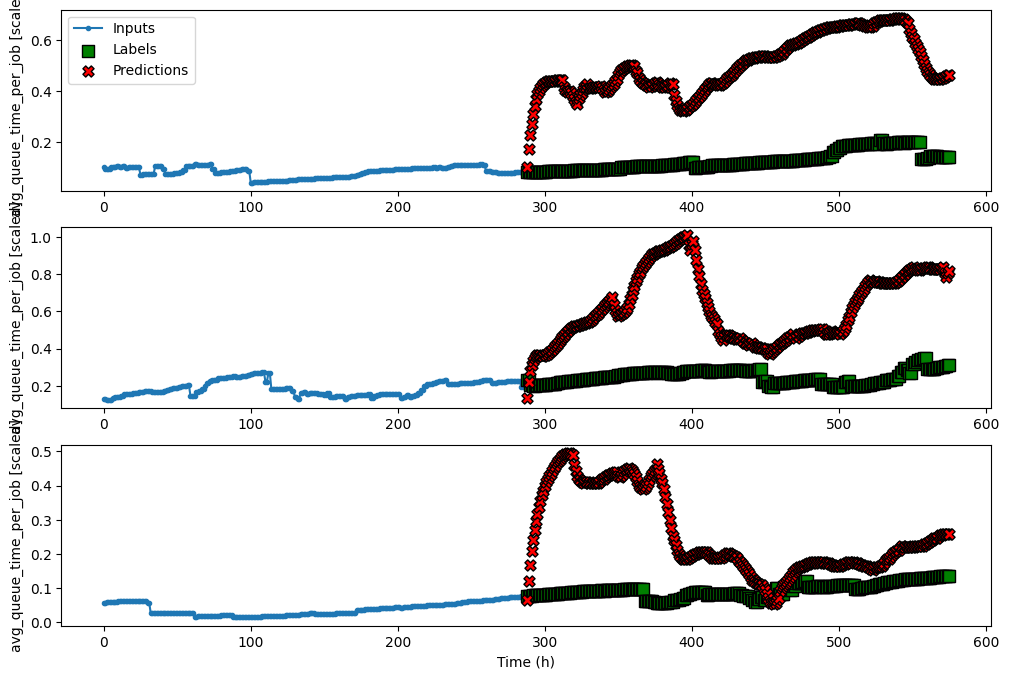

In [53]:
wide_window.plot(ss_lstm_model)

4.1 LSTM multistep model

In [54]:
ms_lstm_model = Sequential([
    LSTM(units=32, return_sequences=True),
    Dense(units=1, kernel_initializer=tf.initializers.zeros),
])

In [55]:
history = compile_and_fit(model=ms_lstm_model, window=multi_window)
ms_val_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.val)
ms_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/100


2023-05-22 16:07:13.931256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-05-22 16:07:13.931810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-05-22 16:07:14.264027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node grad

545/545 [==============================] - ETA: 0s - loss: 0.0124 - mean_absolute_error: 0.0785 - mean_absolute_percentage_error: 12714.8916

2023-05-22 16:08:03.489076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [4567]
	 [[{{node Placeholder/_8}}]]
2023-05-22 16:08:03.489889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-05-22 16:08:03.674719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32


545/545 [==============================] - 53s 93ms/step - loss: 0.0124 - mean_absolute_error: 0.0785 - mean_absolute_percentage_error: 12714.8916 - val_loss: 0.0301 - val_mean_absolute_error: 0.1225 - val_mean_absolute_percentage_error: 45.8279
Epoch 2/100
545/545 [==============================] - 54s 99ms/step - loss: 0.0074 - mean_absolute_error: 0.0629 - mean_absolute_percentage_error: 6803.5366 - val_loss: 0.0418 - val_mean_absolute_error: 0.1600 - val_mean_absolute_percentage_error: 67.7574
Epoch 3/100
545/545 [==============================] - 52s 95ms/step - loss: 0.0054 - mean_absolute_error: 0.0534 - mean_absolute_percentage_error: 2607.2896 - val_loss: 0.0389 - val_mean_absolute_error: 0.1443 - val_mean_absolute_percentage_error: 51.4381
Epoch 4/100
  4/143 [..............................] - ETA: 3s - loss: 0.0467 - mean_absolute_error: 0.1657 - mean_absolute_percentage_error: 63.0783 

2023-05-22 16:10:44.024105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [5142,16]
	 [[{{node Placeholder/_0}}]]
2023-05-22 16:10:44.024647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [5142,16]
	 [[{{node Placeholder/_0}}]]


143/143 [==============================] - 4s 26ms/step - loss: 0.0432 - mean_absolute_error: 0.1603 - mean_absolute_percentage_error: 59.1996


2023-05-22 16:10:47.908403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1996]
	 [[{{node Placeholder/_8}}]]
2023-05-22 16:10:47.908864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1996]
	 [[{{node Placeholder/_8}}]]


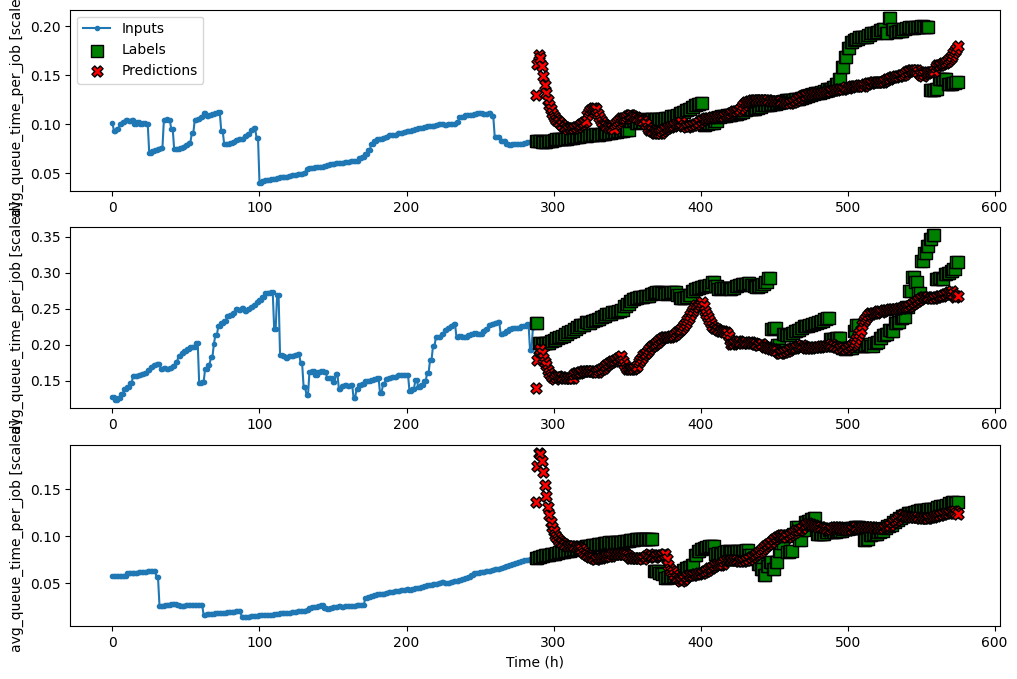

In [56]:
wide_window.plot(ms_lstm_model)

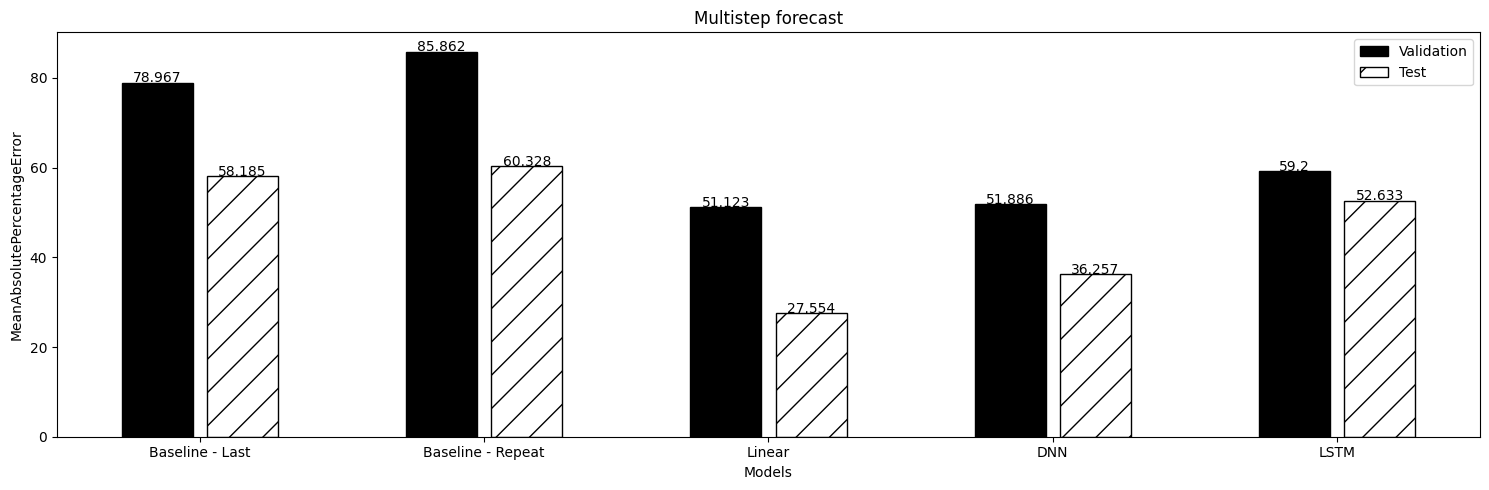

In [57]:
plot_performance(ms_performance, ms_val_performance, high_ylim=0.3, title='Multistep forecast')
#plot_performance(performance, val_performance, high_ylim=0.2, title='Single step forecast')

5- GRU multistep model

In [58]:
ms_gru_model = Sequential([
    GRU(units=64, return_sequences=True),
    Dense(units=1, kernel_initializer=tf.initializers.zeros),
])

In [59]:
history = compile_and_fit(model=ms_gru_model, window=multi_window)
ms_val_performance['GRU'] = ms_gru_model.evaluate(multi_window.val)
ms_performance['GRU'] = ms_gru_model.evaluate(multi_window.test, verbose=0)

Epoch 1/100


2023-05-22 16:11:29.389027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [17995,16]
	 [[{{node Placeholder/_0}}]]
2023-05-22 16:11:29.389611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [17995,16]
	 [[{{node Placeholder/_0}}]]
2023-05-22 16:11:29.727917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split

545/545 [==============================] - ETA: 0s - loss: 0.0133 - mean_absolute_error: 0.0836 - mean_absolute_percentage_error: 12185.3164

2023-05-22 16:12:29.445778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [4567]
	 [[{{node Placeholder/_8}}]]
2023-05-22 16:12:29.446283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [5142,16]
	 [[{{node Placeholder/_0}}]]
2023-05-22 16:12:29.630303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim'

545/545 [==============================] - 64s 113ms/step - loss: 0.0133 - mean_absolute_error: 0.0836 - mean_absolute_percentage_error: 12185.3164 - val_loss: 0.0351 - val_mean_absolute_error: 0.1352 - val_mean_absolute_percentage_error: 48.4162
Epoch 2/100
545/545 [==============================] - 59s 108ms/step - loss: 0.0083 - mean_absolute_error: 0.0672 - mean_absolute_percentage_error: 9037.2852 - val_loss: 0.0346 - val_mean_absolute_error: 0.1406 - val_mean_absolute_percentage_error: 56.8035
Epoch 3/100
545/545 [==============================] - 61s 113ms/step - loss: 0.0060 - mean_absolute_error: 0.0572 - mean_absolute_percentage_error: 2491.5706 - val_loss: 0.0311 - val_mean_absolute_error: 0.1320 - val_mean_absolute_percentage_error: 50.1818
Epoch 4/100
545/545 [==============================] - 59s 109ms/step - loss: 0.0046 - mean_absolute_error: 0.0497 - mean_absolute_percentage_error: 2441.3298 - val_loss: 0.0506 - val_mean_absolute_error: 0.1648 - val_mean_absolute_perce

2023-05-22 16:17:29.174527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [4567]
	 [[{{node Placeholder/_8}}]]
2023-05-22 16:17:29.175101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [5142,16]
	 [[{{node Placeholder/_0}}]]


143/143 [==============================] - 4s 27ms/step - loss: 0.0739 - mean_absolute_error: 0.2010 - mean_absolute_percentage_error: 65.2483


2023-05-22 16:17:33.094803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-05-22 16:17:33.095226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


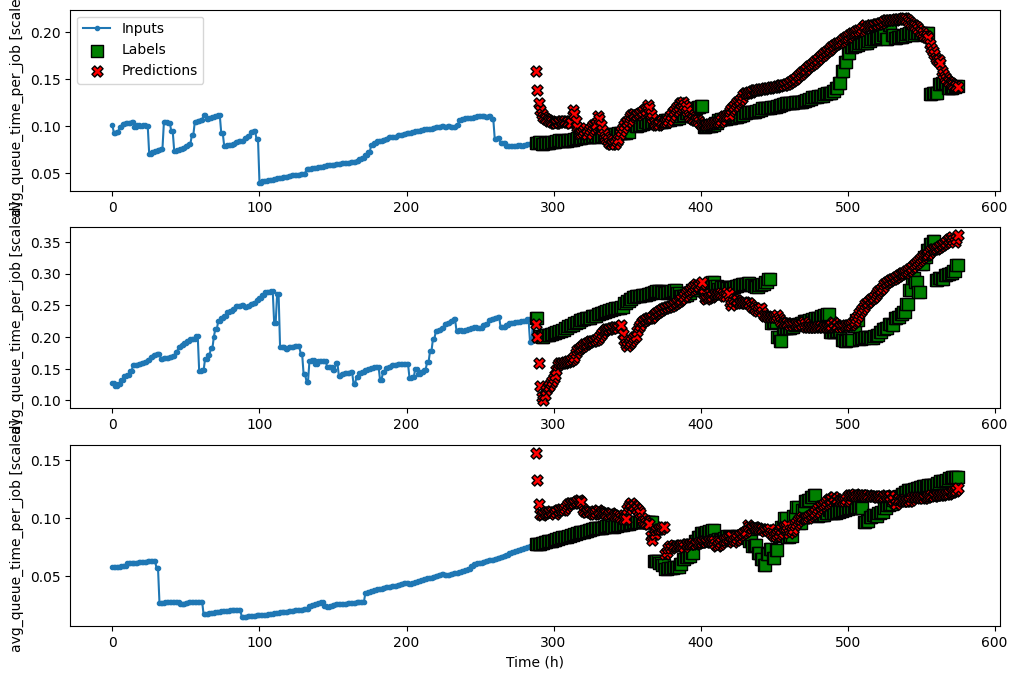

In [60]:
wide_window.plot(ms_gru_model)

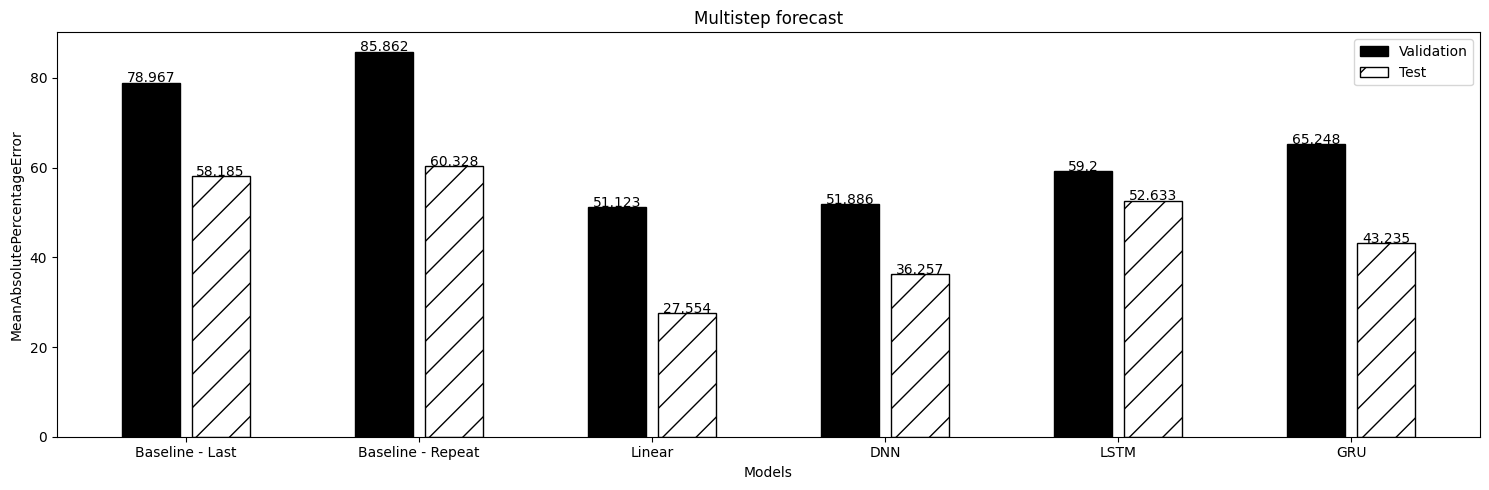

In [61]:
plot_performance(ms_performance, ms_val_performance, high_ylim=0.2, title='Multistep forecast')
#plot_performance(performance, val_performance, high_ylim=0.01, title='Single step forecast')

5- Convolutional Neural Network(CNN) multistep model

In [62]:
KERNEL_WIDTH = a_day_period
LABEL_WIDTH = a_day_period
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1
multi_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=a_day_period, label_columns=['avg_queue_time_per_job'])
wide_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=a_day_period, label_columns=['avg_queue_time_per_job'])

In [63]:
ms_cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation="relu"),
    Dense(units=25, activation="relu"),
    Dense(units=1, kernel_initializer=tf.initializers.zeros)
])

In [64]:
history = compile_and_fit(model=ms_cnn_model, window=multi_conv_window)
ms_val_performance['CNN'] = ms_cnn_model.evaluate(multi_conv_window.val)
ms_performance['CNN'] = ms_cnn_model.evaluate(multi_conv_window.test, verbose=0)

Epoch 1/100


2023-05-22 16:23:44.431664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-05-22 16:23:44.432600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


535/536 [============================>.] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0696 - mean_absolute_percentage_error: 8934.4502

2023-05-22 16:24:25.835888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [4280]
	 [[{{node Placeholder/_8}}]]
2023-05-22 16:24:25.837169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [4280]
	 [[{{node Placeholder/_8}}]]


536/536 [==============================] - 45s 82ms/step - loss: 0.0100 - mean_absolute_error: 0.0696 - mean_absolute_percentage_error: 8930.0635 - val_loss: 0.0462 - val_mean_absolute_error: 0.1421 - val_mean_absolute_percentage_error: 53.0129
Epoch 2/100
536/536 [==============================] - 52s 97ms/step - loss: 0.0025 - mean_absolute_error: 0.0360 - mean_absolute_percentage_error: 2021.8616 - val_loss: 0.0607 - val_mean_absolute_error: 0.1693 - val_mean_absolute_percentage_error: 61.2146
Epoch 3/100
536/536 [==============================] - 53s 100ms/step - loss: 0.0012 - mean_absolute_error: 0.0252 - mean_absolute_percentage_error: 2408.4634 - val_loss: 0.0602 - val_mean_absolute_error: 0.1730 - val_mean_absolute_percentage_error: 60.8615
Epoch 4/100
  7/134 [>.............................] - ETA: 2s - loss: 0.0540 - mean_absolute_error: 0.1602 - mean_absolute_percentage_error: 53.6239

2023-05-22 16:27:07.589995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-05-22 16:27:07.590472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [5142,16]
	 [[{{node Placeholder/_0}}]]


134/134 [==============================] - 3s 20ms/step - loss: 0.0525 - mean_absolute_error: 0.1552 - mean_absolute_percentage_error: 53.5381


2023-05-22 16:27:10.391084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [2571,16]
	 [[{{node Placeholder/_0}}]]
2023-05-22 16:27:10.391573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


2023-05-22 16:27:11.571134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-05-22 16:27:11.571770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


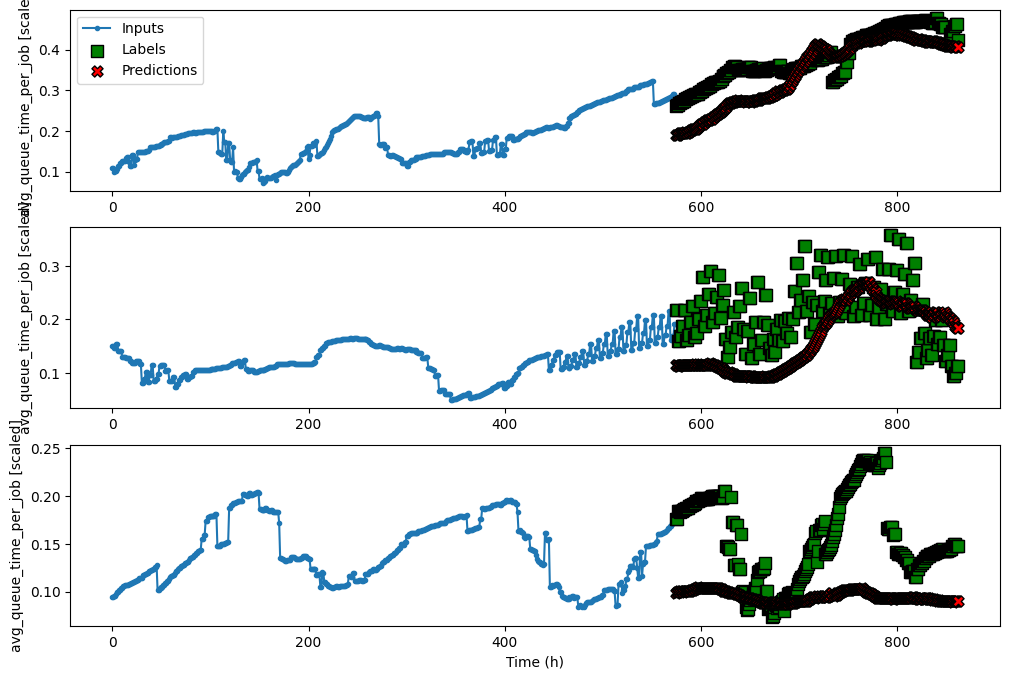

In [65]:
wide_conv_window.plot(ms_cnn_model)

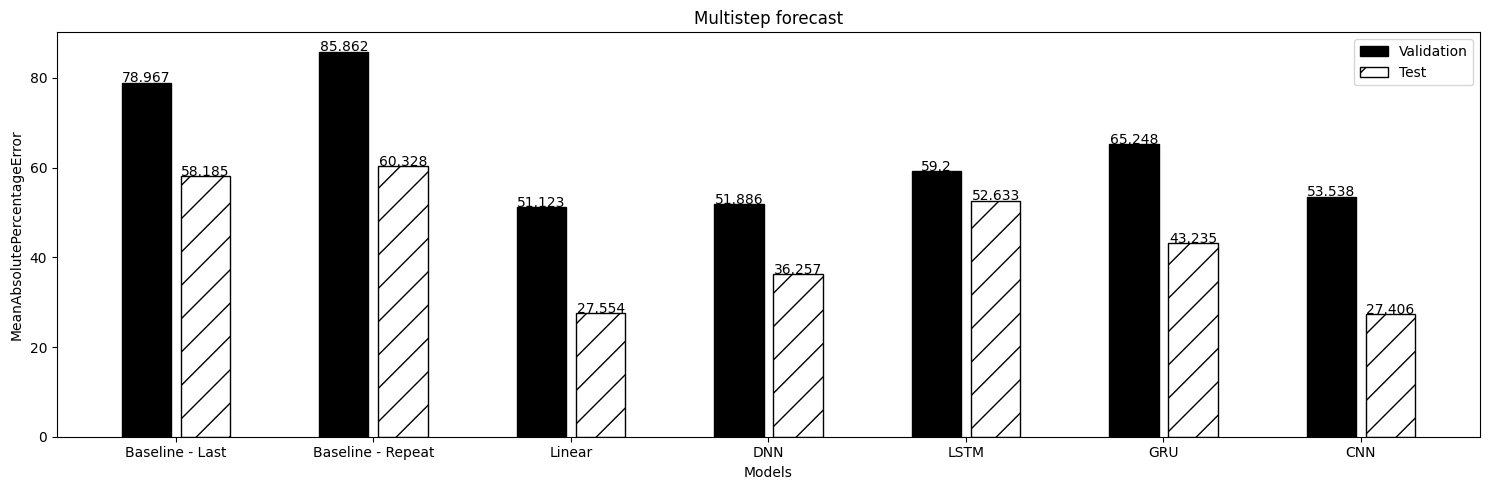

In [66]:
plot_performance(ms_performance, ms_val_performance, high_ylim=0.2, title='Multistep forecast')
#plot_performance(performance, val_performance, high_ylim=0.01, title='Single step forecast')

6- CNN + LSTM multistep model

In [67]:
ms_cnn_lstm_model = Sequential([
    Conv1D(filters=64, kernel_size=(KERNEL_WIDTH,), activation="relu"),
    LSTM(units=64, return_sequences=True),
    Dense(units=1, kernel_initializer=tf.initializers.zeros)
])

In [68]:
history = compile_and_fit(model=ms_cnn_lstm_model, window=multi_conv_window)
ms_val_performance['CNN + LSTM'] = ms_cnn_model.evaluate(multi_conv_window.val)
ms_performance['CNN + LSTM'] = ms_cnn_model.evaluate(multi_conv_window.test, verbose=0)

Epoch 1/100


2023-05-22 16:30:26.235431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [17133]
	 [[{{node Placeholder/_8}}]]
2023-05-22 16:30:26.236338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-05-22 16:30:26.593146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32

536/536 [==============================] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0712 - mean_absolute_percentage_error: 11717.9414

2023-05-22 16:32:28.800945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-05-22 16:32:28.801600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-05-22 16:32:29.017165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node grad

536/536 [==============================] - 133s 243ms/step - loss: 0.0103 - mean_absolute_error: 0.0712 - mean_absolute_percentage_error: 11717.9414 - val_loss: 0.0457 - val_mean_absolute_error: 0.1519 - val_mean_absolute_percentage_error: 54.7153
Epoch 2/100
536/536 [==============================] - 133s 248ms/step - loss: 0.0024 - mean_absolute_error: 0.0348 - mean_absolute_percentage_error: 2074.5151 - val_loss: 0.0525 - val_mean_absolute_error: 0.1664 - val_mean_absolute_percentage_error: 59.6766
Epoch 3/100
536/536 [==============================] - 124s 232ms/step - loss: 8.0281e-04 - mean_absolute_error: 0.0196 - mean_absolute_percentage_error: 954.8988 - val_loss: 0.0543 - val_mean_absolute_error: 0.1692 - val_mean_absolute_percentage_error: 59.1287
Epoch 4/100
  7/134 [>.............................] - ETA: 2s - loss: 0.0504 - mean_absolute_error: 0.1569 - mean_absolute_percentage_error: 53.7248

2023-05-22 16:39:02.120640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [4280]
	 [[{{node Placeholder/_8}}]]
2023-05-22 16:39:02.121220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


134/134 [==============================] - 3s 20ms/step - loss: 0.0525 - mean_absolute_error: 0.1552 - mean_absolute_percentage_error: 53.5382


2023-05-22 16:39:04.829725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1709]
	 [[{{node Placeholder/_8}}]]
2023-05-22 16:39:04.830315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [2571,16]
	 [[{{node Placeholder/_0}}]]


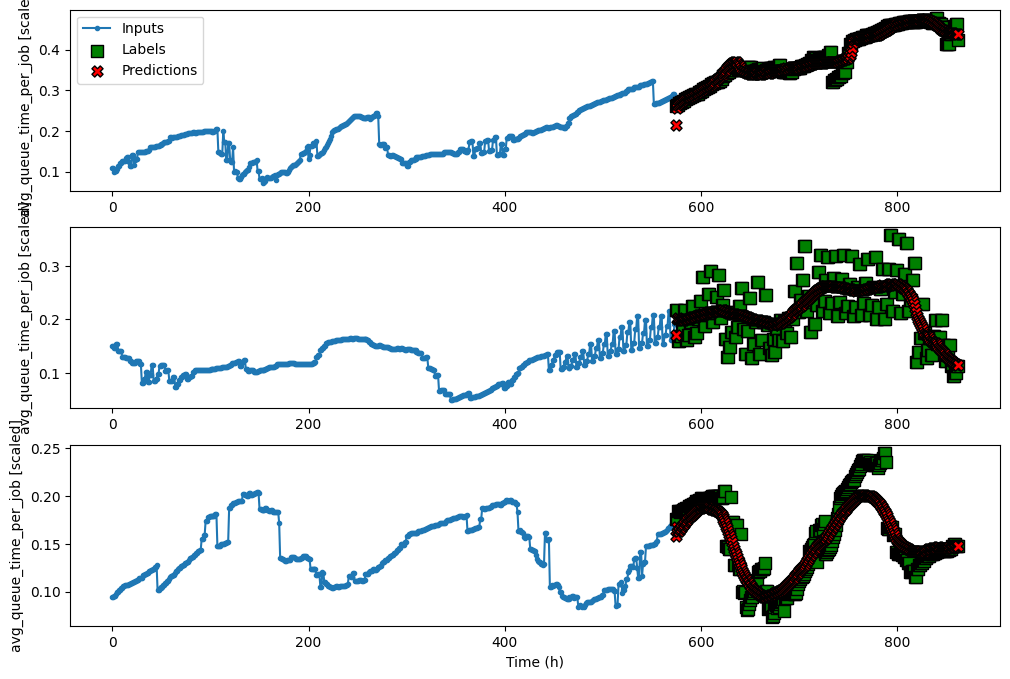

In [69]:
wide_conv_window.plot(ms_cnn_lstm_model)

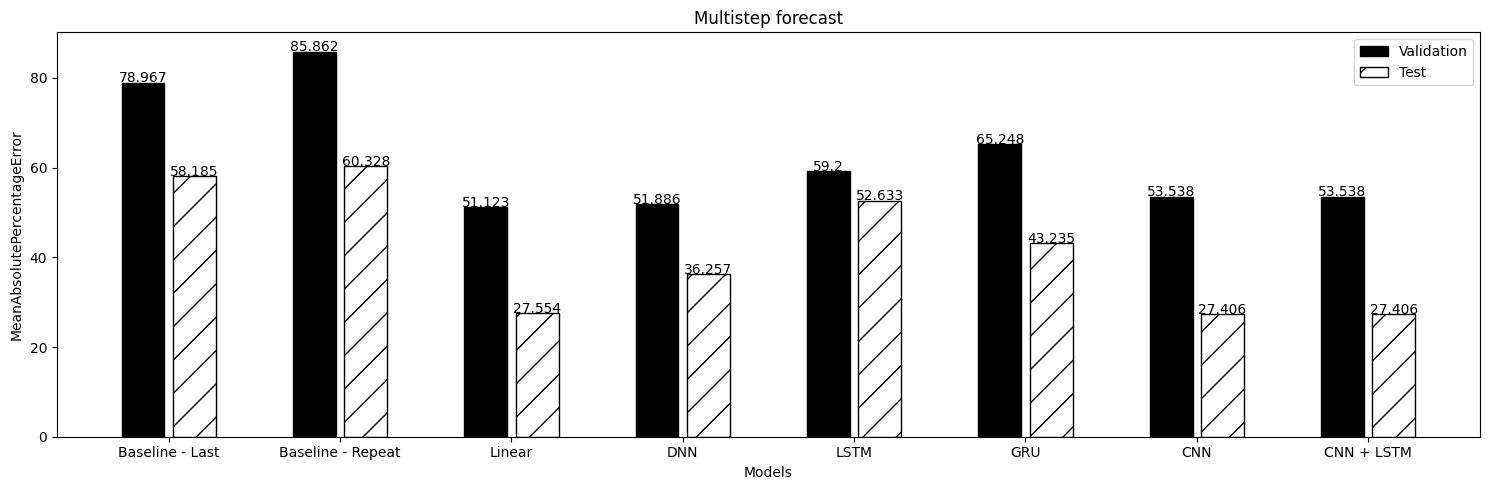

In [70]:
plot_performance(ms_performance, ms_val_performance, high_ylim=0.2, title='Multistep forecast')
#plot_performance(performance, val_performance, high_ylim=0.01, title='Single step forecast')

Autoregressive LSTM (ARLSTM)

In [71]:
class AutoRegressive(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(train_df.shape[1])

    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
        return prediction, state
    
    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        predictions.append(prediction)
        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)
            prediction = self.dense(x)
            predictions.append(prediction)
        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions


In [72]:
ar_multi_window = DataWindow(input_width=a_day_period, label_width=a_day_period, shift=a_day_period, label_columns=['avg_queue_time_per_job'])

In [73]:
AR_LSTM = AutoRegressive(units=32, out_steps=a_day_period)
history = compile_and_fit(AR_LSTM, ar_multi_window)

Epoch 1/100


2023-05-22 16:40:49.329392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [17995,16]
	 [[{{node Placeholder/_0}}]]
2023-05-22 16:40:49.330045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [17420]
	 [[{{node Placeholder/_8}}]]


545/545 [==============================] - ETA: 0s - loss: 0.0285 - mean_absolute_error: 0.1233 - mean_absolute_percentage_error: 22325.9199

2023-05-22 16:42:53.236861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-05-22 16:42:53.237399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


545/545 [==============================] - 138s 153ms/step - loss: 0.0285 - mean_absolute_error: 0.1233 - mean_absolute_percentage_error: 22325.9199 - val_loss: 0.0506 - val_mean_absolute_error: 0.1553 - val_mean_absolute_percentage_error: 47.5987
Epoch 2/100
545/545 [==============================] - 80s 147ms/step - loss: 0.0259 - mean_absolute_error: 0.1181 - mean_absolute_percentage_error: 22482.1777 - val_loss: 0.0479 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 46.7853
Epoch 3/100
545/545 [==============================] - 86s 158ms/step - loss: 0.0303 - mean_absolute_error: 0.1300 - mean_absolute_percentage_error: 25184.3535 - val_loss: 0.0462 - val_mean_absolute_error: 0.1437 - val_mean_absolute_percentage_error: 46.8521
Epoch 4/100
545/545 [==============================] - 77s 141ms/step - loss: 0.0301 - mean_absolute_error: 0.1296 - mean_absolute_percentage_error: 25144.0977 - val_loss: 0.0545 - val_mean_absolute_error: 0.1626 - val_mean_absolute_p

In [74]:
ms_val_performance['AR - LSTM'] = AR_LSTM.evaluate(ar_multi_window.val)
ms_performance['AR - LSTM'] = AR_LSTM.evaluate(ar_multi_window.test, verbose=0)

  1/143 [..............................] - ETA: 16s - loss: 0.0333 - mean_absolute_error: 0.1302 - mean_absolute_percentage_error: 38.8456

2023-05-22 16:49:55.773516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-05-22 16:49:55.774332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


143/143 [==============================] - 7s 45ms/step - loss: 0.0469 - mean_absolute_error: 0.1450 - mean_absolute_percentage_error: 46.8071


2023-05-22 16:50:02.355913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [2571,16]
	 [[{{node Placeholder/_0}}]]
2023-05-22 16:50:02.356573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1996]
	 [[{{node Placeholder/_8}}]]


2023-05-22 16:50:05.396140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [17995,16]
	 [[{{node Placeholder/_0}}]]
2023-05-22 16:50:05.397536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [17995,16]
	 [[{{node Placeholder/_0}}]]


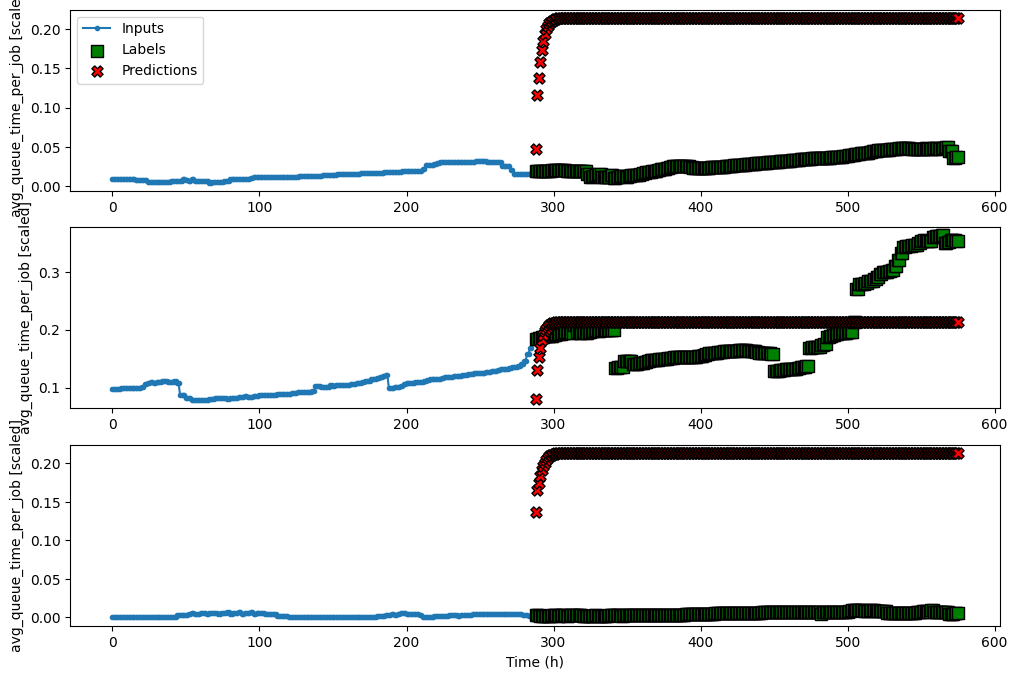

In [75]:
ar_multi_window.plot(AR_LSTM)

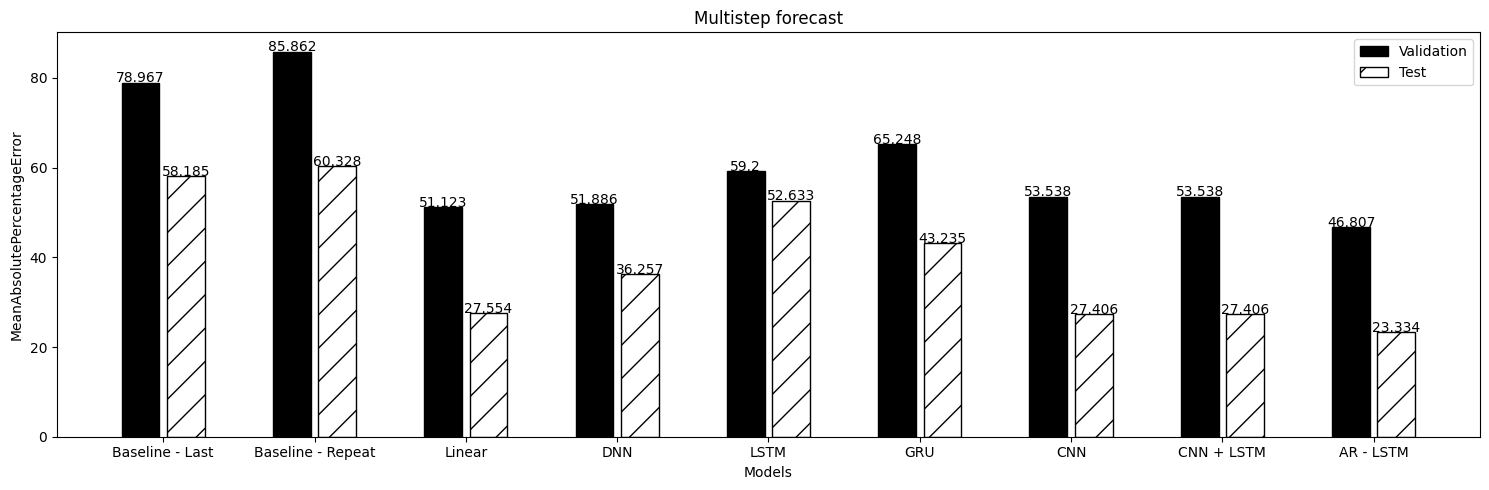

In [77]:
plot_performance(ms_performance, ms_val_performance, high_ylim=0.2, title='Multistep forecast')
#plot_performance(performance, val_performance, high_ylim=0.1, title='Single step forecast')

AR-LSTM provides the better results. 
TODO: Investigate training with one day/week window and forecast for a day
TODO: If results are promising, investigate hyperparameter optimization